# CHE

In [19]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
pd.__version__
import sys
from scipy import stats
%matplotlib inline
import sys
from scipy import stats
import sklearn.neighbors as neighbors

## Calculate different geometric building features from Geojson files

In [20]:
import glob
import os
path = 'data\osm'
all_patches_names = []
counter = 0
for filename in glob.glob(os.path.join(path, '*.geojson')):
    all_patches_names.append(filename)
    print(filename)

data\osm\buildings_liechtenstein.geojson
data\osm\buildings_switzerland.geojson
data\osm\station.geojson


In [21]:
buildings_path = all_patches_names[1]

In [22]:
import geopandas as gpd
patch = gpd.read_file(buildings_path)
patch.head(5)

osm_id                      name          type     amenity    building  \
0   2364  Kantonsschule Rychenberg  multipolygon      school      school   
1   4264                      None  multipolygon        None  university   
2   4436            Bezirksgebäude  multipolygon  courthouse         yes   
3   4445                      None  multipolygon        None  university   
4   4633                      None  multipolygon  university      school   

                                          other_tags office tourism historic  \
0  "addr:housenumber"=>"110","addr:street"=>"Rych...   None    None     None   
1  "addr:city"=>"Zürich","addr:housename"=>"ETH H...   None    None     None   
2                            "wikidata"=>"Q29933529"   None    None     None   
3  "addr:city"=>"Zürich","addr:housename"=>"ETH C...   None    None     None   
4                        "addr:housename"=>"ETH CHN"   None    None     None   

  man_made  ...  shop military landuse natural osm_way_id aeroway barrier  \
0     None  ...  None     None    None    None       None    None    None   
1     None  ...  None     None    None    None       None    None    None   
2     None  ...  None     None    None    None       None    None    None   
3     None  ...  None     None    None    None       None    None    None   
4     None  ...  None     None    None    None       None    None    None   

  place boundary                                           geometry  
0  None     None  (POLYGON ((8.736886399999999 47.5053704, 8.736...  
1  None     None  (POLYGON ((8.507471300000001 47.4094702, 8.507...  
2  None     None  (POLYGON ((8.5260471 47.3742349, 8.52602989999...  
3  None     None  (POLYGON ((8.549374500000001 47.3780957, 8.549...  
4  None     None  (POLYGON ((8.5483092 47.3799203, 8.5485753 47....  

[5 rows x 23 columns]

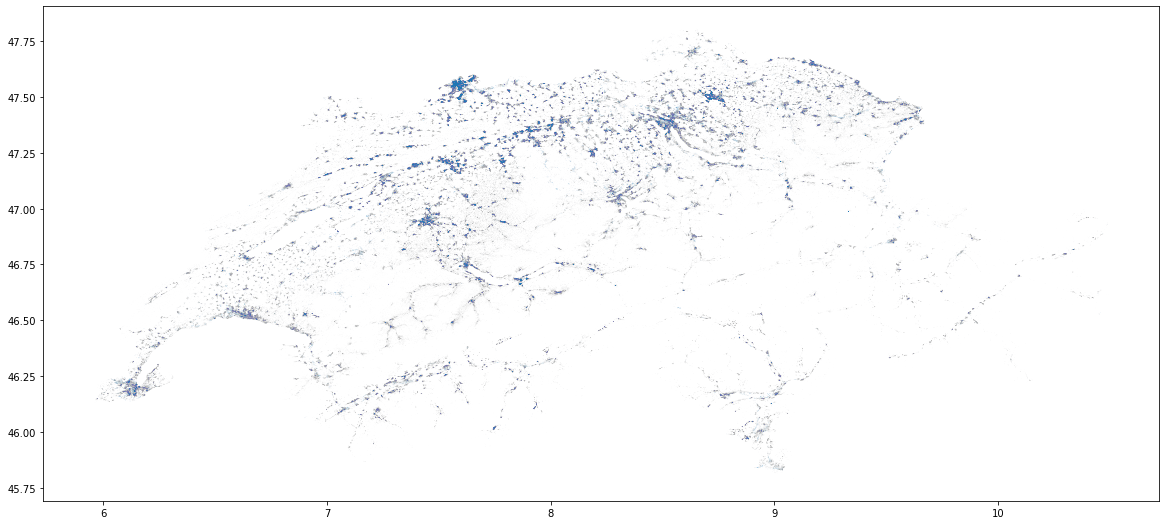

In [23]:
patch.plot(figsize=(20, 25));

In [26]:
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.ops import cascaded_union
import fiona

In [27]:
all_areas = []
all_no_coords = []
all_xs = [] 
all_ys = []
all_building_types = []

In [28]:
with fiona.open(buildings_path,) as f:
    crs = f.crs
    iterate = 0
    for rec in f:
        if rec['geometry']['type'] == 'MultiPolygon':
            polygons = MultiPolygon([Polygon(rec['geometry']['coordinates'][0][i])
                                     for i in range(len(rec['geometry']['coordinates'][0]))])
            try:
                areas = cascaded_union(polygons).area
            except:
                print('does not work')
                areas = 0

        no_coords = [len(polygons[i].exterior.coords)-1 for i in range(len(polygons))]
        no_coords = np.sum(no_coords)
        all_areas.append(areas)
        all_no_coords.append(no_coords)
        all_xs.append(polygons.centroid.xy[0][0])
        all_ys.append(polygons.centroid.xy[1][0])
        try:
            all_building_types.append(str(rec['properties']['building']))
        except:
            all_building_types.append(str('yes'))


        iterate = iterate +1
print ("polygon: ",iterate)

polygon:  2364955


In [29]:
DF =pd.DataFrame()
DF['area'] = all_areas
DF['corners'] = all_no_coords
DF['x_center'] = all_xs
DF['y_center'] = all_ys
DF['type'] = all_building_types

In [30]:
buildings_path = "data\\osm\\"

csv_path = buildings_path+'switzerland'+'-building.csv'
DF.to_csv(path_or_buf=csv_path,index=False)
print ('CSV done')

CSV done


## Calculating building analytics based on distribution of different POIs

In [31]:
import os
input_n  = 'C:/Users/GAO/Downloads/switzerland.osm.pbf'
output_n = input_n.replace('osm.pbf','pois.csv')
os.system('java -Xmx32g -jar osmpois.jar --outputTags , --outputFile {} {}'.format(output_n,input_n));

In [32]:
pois = pd.read_csv(output_n,sep='|',header=None).dropna()

In [33]:
pois.index = range(pois.shape[0])
pois.columns = ['type_code','OSM-ID','lat','lon']
pois['type_code'] = pois['type_code'].values[:].astype(int)

In [34]:
pois.head(5)

type_code    OSM-ID        lat       lon
0          6  N6080794  46.496346  7.565037
1          6  N6081329  46.492204  7.556231
2        161  N8096185  46.721077  8.318217
3        161  N8096208  46.730147  8.333350
4        161  N8096209  46.732279  8.338445

In [35]:
poi_type_met = pd.read_csv('C:/Users/GAO/Downloads/poi_types.csv').dropna()

In [36]:
poi_type_met.index = range(poi_type_met.shape[0])
poi_type_met.columns = ['POI TYPE','type_code']
poi_type_met['type_code'] = poi_type_met['type_code'].values[:].astype(int)

In [37]:
merged = pd.merge(pois,poi_type_met,on='type_code',how='outer').dropna()

In [38]:
merged.head(5)

type_code     OSM-ID        lat       lon       POI TYPE
0          6   N6080794  46.496346  7.565037  ACCOMMO_HOTEL
1          6   N6081329  46.492204  7.556231  ACCOMMO_HOTEL
2          6  N31819592  46.958920  7.457860  ACCOMMO_HOTEL
3          6  N32654789  46.958650  7.464330  ACCOMMO_HOTEL
4          6  N32654790  46.953739  7.432654  ACCOMMO_HOTEL

In [39]:
output_n = output_n.replace('pois.csv','pois-with-types.csv')
merged.to_csv(output_n,index=False)

In [40]:
_pois = pd.read_csv('C:/Users/GAO/Downloads/switzerland.pois-with-types.csv')

In [41]:
gb = _pois.groupby(by='POI TYPE')
poi_groups = gb.count()
poi_groups = poi_groups.sort_values('lat',ascending=False)
top_poi_categories = poi_groups.head(15).index[:].values[:]
poi_groups.head(15)

type_code  OSM-ID    lat    lon
POI TYPE                                             
TRANSPORT_BUSSTOP         33299   33299  33299  33299
FOOD_RESTAURANT           14937   14937  14937  14937
POI_HAMLET                11741   11741  11741  11741
POI_PEAK                   5430    5430   5430   5430
EDUCATION_SCHOOL           5071    5071   5071   5071
SHOP_DEPARTMENTSTORE       4501    4501   4501   4501
SHOP_SUPERMARKET           3878    3878   3878   3878
POW_CHRISTIAN              3823    3823   3823   3823
ACCOMMO_HOTEL              3665    3665   3665   3665
POI_VILLAGE                3568    3568   3568   3568
SHOP_HAIRDRESSER           3046    3046   3046   3046
TRANSPORT_STATION          2854    2854   2854   2854
SHOP_CLOTHES               2852    2852   2852   2852
FOOD_CAFE                  2471    2471   2471   2471
LANDUSE_GRASS              2268    2268   2268   2268

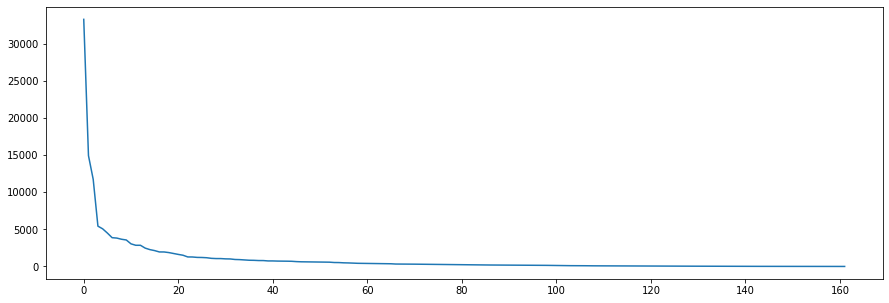

In [42]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.plot(poi_groups.type_code.values[:]);

## Main categories of POIs

In [43]:
poi_types = np.unique([x.split('_')[0] for x in poi_groups.index.values[:]])
print(poi_types)

['ACCOMMO' 'AMENITY' 'BARRIER' 'EDUCATION' 'FOOD' 'HEALTH' 'LANDUSE'
 'MONEY' 'POI' 'POW' 'SHOP' 'SPORT' 'TOURIST' 'TRANSPORT' 'WATER']


In [44]:
chosen_r = 500
keys = [str(p) for p in poi_groups.index.values[:]]

In [45]:
sel_types = []
sel_type = 'TRANSPORT'
for c in keys:
    if sel_type in c:
        sel_types.append(c)
print (sel_types)

['TRANSPORT_BUSSTOP', 'TRANSPORT_STATION', 'TRANSPORT_FUEL', 'TRANSPORT_TRAMSTOP', 'TRANSPORT_RENTALCAR', 'TRANSPORT_MARINA', 'TRANSPORT_AIRPORT', 'TRANSPORT_TERMINAL', 'TRANSPORT_SUBWAY', 'TRANSPORT_LIGHTHOUSE']


In [46]:
import glob
import os
building_path = 'C:\\Users\\GAO\\Jupyter\\data\\osm\\'

all_building_names = []
counter = 1
for filename in glob.glob(os.path.join(building_path, '*.csv')):
    all_building_names.append(filename)

print (len(all_building_names))

2


In [48]:
all_building_names.pop(0)

'C:\\Users\\GAO\\Jupyter\\data\\osm\\liechtenstein-building.csv'

In [49]:
all_building_names

['C:\\Users\\GAO\\Jupyter\\data\\osm\\switzerland-building.csv']

In [50]:
# Path to qualified buildings for each POI
path = building_path+'OSM_pois_neigh\\'

In [51]:
path

'C:\\Users\\GAO\\Jupyter\\data\\osm\\OSM_pois_neigh\\'

In [52]:
import sklearn.neighbors as neighbors

for count, key in enumerate(sel_types[:]):
    inds = list(np.where(_pois['POI TYPE'].values[:]==key)[0])
    print (count,key, len(inds))
    sel_poi = _pois.loc[inds]
    coords_poi = sel_poi[['lat','lon']].values[:]

    tree = neighbors.BallTree(np.radians(coords_poi), metric='haversine')     
    # Here we look on a spatial radius around each buildings
    # And simply count the number of each POI in that distance
    ms_per_radian = 6371008.8
    r = chosen_r #in meters
    r_query = r/ms_per_radian
    for i , filename in enumerate(all_building_names[:]):
        what_aspect = 'x_center','y_center'
        buildings =  pd.read_csv(filename,usecols=what_aspect)
        buildings.columns= ['lon','lat']
        buildings_with_neigh = buildings.copy()
        buildings_with_neigh[key] = tree.query_radius(np.radians(buildings_with_neigh[['lat','lon']].values[:]),
                                                          r=r_query, count_only=True)
        buildings_with_neigh.to_csv(path_or_buf=path+'switzerland-building_{}.csv'.format(key),index=False)

0 TRANSPORT_BUSSTOP 33299
1 TRANSPORT_STATION 2854
2 TRANSPORT_FUEL 1955
3 TRANSPORT_TRAMSTOP 1176
4 TRANSPORT_RENTALCAR 290
5 TRANSPORT_MARINA 211
6 TRANSPORT_AIRPORT 60
7 TRANSPORT_TERMINAL 16
8 TRANSPORT_SUBWAY 4
9 TRANSPORT_LIGHTHOUSE 1


In [53]:
all_csv_names = []
for filename in glob.glob(os.path.join(path, '*.csv')):
    #for each POI type and each country there is a unique CSV
    all_csv_names.append(filename)

In [54]:
all_csv_names

['C:\\Users\\GAO\\Jupyter\\data\\osm\\OSM_pois_neigh\\switzerland-building_TRANSPORT_AIRPORT.csv',
 'C:\\Users\\GAO\\Jupyter\\data\\osm\\OSM_pois_neigh\\switzerland-building_TRANSPORT_BUSSTOP.csv',
 'C:\\Users\\GAO\\Jupyter\\data\\osm\\OSM_pois_neigh\\switzerland-building_TRANSPORT_FUEL.csv',
 'C:\\Users\\GAO\\Jupyter\\data\\osm\\OSM_pois_neigh\\switzerland-building_TRANSPORT_LIGHTHOUSE.csv',
 'C:\\Users\\GAO\\Jupyter\\data\\osm\\OSM_pois_neigh\\switzerland-building_TRANSPORT_MARINA.csv',
 'C:\\Users\\GAO\\Jupyter\\data\\osm\\OSM_pois_neigh\\switzerland-building_TRANSPORT_RENTALCAR.csv',
 'C:\\Users\\GAO\\Jupyter\\data\\osm\\OSM_pois_neigh\\switzerland-building_TRANSPORT_STATION.csv',
 'C:\\Users\\GAO\\Jupyter\\data\\osm\\OSM_pois_neigh\\switzerland-building_TRANSPORT_SUBWAY.csv',
 'C:\\Users\\GAO\\Jupyter\\data\\osm\\OSM_pois_neigh\\switzerland-building_TRANSPORT_TERMINAL.csv',
 'C:\\Users\\GAO\\Jupyter\\data\\osm\\OSM_pois_neigh\\switzerland-building_TRANSPORT_TRAMSTOP.csv']

In [58]:
station = pd.read_csv(all_csv_names[1])
station = gpd.GeoDataFrame(station)

In [59]:
geometry = [Point(xy) for xy in zip(station['lon'].astype(float), station['lat'].astype(float))]

In [60]:
station = gpd.GeoDataFrame(station, crs=crs, geometry=geometry)

In [61]:
station.to_file("data/osm/OSM_pois_neigh/station.geojson", driver='GeoJSON')

In [62]:
station = station.to_crs(epsg=3857)

In [63]:
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

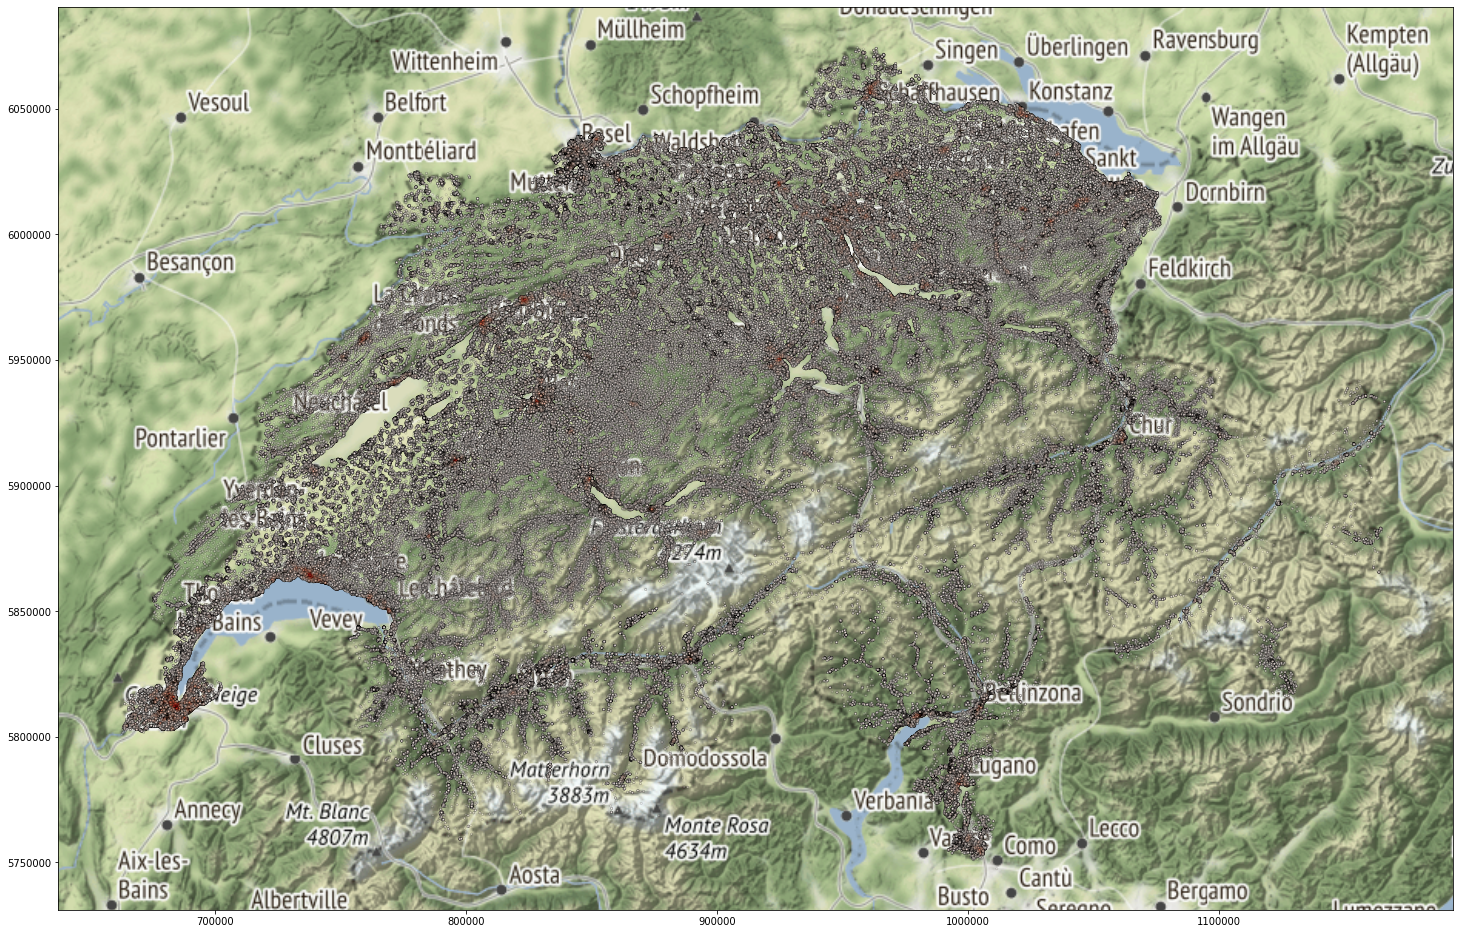

In [71]:
ax = station.plot(figsize=(25, 25), alpha=0.2, column='TRANSPORT_BUSSTOP', cmap='Reds', edgecolor='k', markersize=5, linewidth=0.5)
add_basemap(ax, zoom=8)

## Interactive Map with Mapbox

[Interactive Map](https://ganagno.github.io/maps/che.html)